In [1]:
import os
import csv
import gzip
from io import StringIO
from urllib.request import urlopen
from dateutil.parser import parse
from shapely import geometry
from pystac.extensions.eo import Band
from pystac import *
from shapely.geometry import Point, Polygon, mapping
import json
from datetime import datetime

os.chdir('/workspace/terradue.data/Test/Resources/LANDSAT8/')

## Read Metadata MTL.txt

In [2]:
mtl_txt = 'L1T/data/LC80330352013157LGN00/LC80330352013157LGN00_MTL.txt'

mtl_dict = {} 

# creating dictionary 
with open(mtl_txt) as f: 
    
    for line in f.read().splitlines()[:-1]: # all lines but last one finishing in 'END'
        # reads each line, split command and description
        command, description = line.strip().split(' = ')
        
        # write to dict only actual metadata variables, not GROUP nor END_GROUP
        if command != 'GROUP' and command != 'END_GROUP': mtl_dict[command] = description.strip('"')

# # To write out to file (not necessary)
# out_file = open("test1.json", "w") 
# json.dump(mtl_dict, out_file, indent = 4, sort_keys = False) 
# out_file.close()

# mtl_dict

In [3]:
# Call the pystac help to see what's required
help(pystac.Item.__init__)

Help on function __init__ in module pystac.item:

__init__(self, id, geometry, bbox, datetime, properties, stac_extensions=None, href=None, collection=None, extra_fields=None)
    Initialize self.  See help(type(self)) for accurate signature.



## Get Identifier

In [4]:
item_id = mtl_dict['LANDSAT_SCENE_ID']
item_id

'LC80330352013157LGN00'

## Get Image Geometry and BBOX


In [5]:
p1 = Point(float(mtl_dict['CORNER_UL_LON_PRODUCT']), float(mtl_dict['CORNER_UL_LAT_PRODUCT'])); print(p1)
p2 = Point(float(mtl_dict['CORNER_UR_LON_PRODUCT']), float(mtl_dict['CORNER_UR_LAT_PRODUCT'])); print(p2)
p3 = Point(float(mtl_dict['CORNER_LR_LON_PRODUCT']), float(mtl_dict['CORNER_LR_LAT_PRODUCT'])); print(p3)
p4 = Point(float(mtl_dict['CORNER_LL_LON_PRODUCT']), float(mtl_dict['CORNER_LL_LAT_PRODUCT'])); print(p4)
p5 = Point(float(mtl_dict['CORNER_UL_LON_PRODUCT']), float(mtl_dict['CORNER_UL_LAT_PRODUCT'])); print(p5)

POINT (-106.85401 37.03264)
POINT (-104.28029 37.04494)
POINT (-104.29837 35.03275)
POINT (-106.80746 35.02132)
POINT (-106.85401 37.03264)


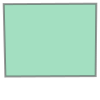

In [6]:
footprint = Polygon([p.x, p.y] for p in [p1, p2, p3, p4, p5])

footprint

In [7]:
bbox = list(footprint.bounds)

bbox

[-106.85401, 35.02132, -104.28029, 37.04494]

In [8]:
geometry = mapping(footprint)

display(geometry)
# print(json.dumps(geometry, indent=2))

{'type': 'Polygon',
 'coordinates': (((-106.85401, 37.03264),
   (-104.28029, 37.04494),
   (-104.29837, 35.03275),
   (-106.80746, 35.02132),
   (-106.85401, 37.03264)),)}

## Get Date and Time

In [9]:
datetime = datetime.strptime(mtl_dict['FILE_DATE'], '%Y-%m-%dT%H:%M:%SZ')
datetime

datetime.datetime(2013, 6, 6, 22, 9, 28)

## Create the Item

In [10]:
# !pip install pystac[validation] # we should add these to the environment.yml if it's needed.

In [11]:
item = pystac.Item(id=item_id, 
                   geometry=mapping(footprint),
                   bbox=bbox,
                   datetime=datetime,
                   properties={})
item.validate()

In [12]:
# Add Ground Sample Distance
item.common_metadata.gsd = float(min(mtl_dict['GRID_CELL_SIZE_PANCHROMATIC'], mtl_dict['GRID_CELL_SIZE_REFLECTIVE'], mtl_dict['GRID_CELL_SIZE_THERMAL']))
item.common_metadata.gsd

15.0

In [13]:
# Add the EO Extension 
item.ext.enable('eo')

In [14]:
# Add Cloud Cover
item.ext.eo.cloud_cover = float(mtl_dict['CLOUD_COVER'])
item.ext.eo.cloud_cover

12.55

## Add Assets

In [15]:
from pystac.extensions.eo import Band

l8_band_info = {
    'B1':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_1']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B1",
                                                common_name="coastal", 
                                                center_wavelength=0.44, 
                                                full_width_half_max=0.02),
        'gsd': 30.0,
        'title':'Band 1 (coastal)'
    },
    
    'B2':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_2']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B2",
                                                common_name="blue", 
                                                center_wavelength=0.48, 
                                                full_width_half_max=0.06),
        'gsd': 30.0,
        'title':'Band 2 (blue)'
    },
    
    'B3':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_3']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B3",
                                                common_name="green", 
                                                center_wavelength=0.56, 
                                                full_width_half_max=0.06),
        'gsd': 30.0,
        'title':'Band 3 (green)'
    },
    
    'B4':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_4']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B4",
                                                common_name="red", 
                                                center_wavelength=0.65, 
                                                full_width_half_max=0.04),
        'gsd': 30.0,
        'title':'Band 4 (red)'
    },
    
    'B5':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_5']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B5",
                                                common_name="nir", 
                                                center_wavelength=0.86, 
                                                full_width_half_max=0.03),
        'gsd': 30.0,
        'title':'Band 5 (nir)'
    },
    
    'B6':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_6']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B6",
                                                common_name="swir16", 
                                                center_wavelength=1.6, 
                                                full_width_half_max=0.08),
        'gsd': 30.0,
        'title':'Band 6 (swir16)'
    },
    
    'B7':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_7']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B7",
                                                common_name="swir22", 
                                                center_wavelength=2.2, 
                                                full_width_half_max=0.2),
        'gsd': 30.0,
        'title':'Band 7 (swir22)'
    },
    
    'B8':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_8']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B8",
                                                common_name="pan", 
                                                center_wavelength=0.59, 
                                                full_width_half_max=0.18),
        'gsd': 15.0,
        'title':'Band 8 (pan)'
    },
    
    'B9':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_9']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B9",
                                                common_name="cirrus", 
                                                center_wavelength=1.37, 
                                                full_width_half_max=0.02),
        'gsd': 30.0,
        'title':'Band 9 (cirrus)'
    },
    
    'B10':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_10']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B10",
                                                common_name="lwir11", 
                                                center_wavelength=10.9, 
                                                full_width_half_max=0.8),
        'gsd': 100.0,
        'title':'Band 10 (lwir11)'
    },
    
    'B11':{
        'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_11']),
        'type':pystac.MediaType.GEOTIFF,
        'band':pystac.extensions.eo.Band.create(name="B11",
                                                common_name="lwir12", 
                                                center_wavelength=12, 
                                                full_width_half_max=1),
        'gsd': 100.0,
        'title':'Band 11 (lwir12)'
    }

}
l8_band_info

{'B1': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B1.TIF',
  'type': 'image/tiff; application=geotiff',
  'band': <Band name=B1>,
  'gsd': 30.0,
  'title': 'Band 1 (coastal)'},
 'B2': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B2.TIF',
  'type': 'image/tiff; application=geotiff',
  'band': <Band name=B2>,
  'gsd': 30.0,
  'title': 'Band 2 (blue)'},
 'B3': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B3.TIF',
  'type': 'image/tiff; application=geotiff',
  'band': <Band name=B3>,
  'gsd': 30.0,
  'title': 'Band 3 (green)'},
 'B4': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B4.TIF',
  'type': 'image/tiff; application=geotiff',
  'band': <Band name=B4>,
  'gsd': 30.0,
  'title': 'Band 4 (red)'},
 'B5': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B5.TIF',
  'type': 'image/tiff; application=geotiff',
  'band': <Band name=B5>,
  'gsd': 30.0,
  'title': 'Band 5 (nir)'},
 'B6': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B6.TIF',
  '

In [16]:
# Other Assets

"""Note the hrefs are not defined properly. Either edit and use the 
function below (taken from here: https://pystac.readthedocs.io/en/latest/tutorials/creating-a-landsat-stac.html)
), or define the href directly in the dictionary such as it's been 
done for BQA and MTL"""

# def get_asset_url(scene, suffix):
#     product_id = scene['productId']
#     download_url = scene['download_url']
#     asset_filename = '{}_{}'.format(product_id, suffix)
#     return download_url.replace('index.html', asset_filename)

#def get_other_assets(scene):
def get_other_assets():
    return {
            'BQA':{
                'href':'{}/{}'.format(item_id,mtl_dict['FILE_NAME_BAND_QUALITY']),
                'media_type':pystac.MediaType.GEOTIFF,
                'title':'Band QA'
            },
            'MTL':{
                'href':'{}/{}'.format(item_id,mtl_dict['METADATA_FILE_NAME']),
                'media_type':'text/plain',
                'title':'MTL'
            }
#             """,
#             'thumbnail': {
#                 'href': get_asset_url(scene, 'thumb_large.jpg'),
#                 'media_type': pystac.MediaType.JPEG
#             },
#             'index': {
#                 'href': get_asset_url(scene, 'index.html'),
#                 'media_type': 'application/html'
#             },
#             'ANG': {
#                 'href': get_asset_url(scene, 'ANG.txt'),
#                 'media_type': 'text/plain'
#             }"""
    }

In [17]:
# Add assets bands to the item
for band_id, band_info in l8_band_info.items():
    bands = [band_info['band']]
    asset = pystac.Asset(href=band_info['href'],
                         media_type=band_info['type'],
                         roles=['data'])
    item.ext.eo.set_bands(bands, asset)
    #item.ext.eo.gsd(bands, band_info['gsd'])
    item.add_asset(band_id, asset)

# Add other assets
for asset_id, asset_info in get_other_assets().items(): #get_other_assets(scene)
    asset = pystac.Asset(href=asset_info['href'], 
                         media_type=asset_info['media_type'])
    item.add_asset(asset_id,asset)
    
display(item.assets)

{'B1': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B1.TIF>,
 'B2': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B2.TIF>,
 'B3': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B3.TIF>,
 'B4': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B4.TIF>,
 'B5': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B5.TIF>,
 'B6': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B6.TIF>,
 'B7': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B7.TIF>,
 'B8': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B8.TIF>,
 'B9': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B9.TIF>,
 'B10': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B10.TIF>,
 'B11': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_B11.TIF>,
 'BQA': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_BQA.TIF>,
 'MTL': <Asset href=LC80330352013157LGN00/LC80330352013157LGN00_MTL.txt>}

In [18]:
# print an example to dictionary
display(item.assets['B4'].to_dict())

# print an example to dictionary
display(item.assets['MTL'].to_dict())

{'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B4.TIF',
 'type': 'image/tiff; application=geotiff',
 'eo:bands': [{'name': 'B4',
   'common_name': 'red',
   'center_wavelength': 0.65,
   'full_width_half_max': 0.04}],
 'roles': ['data']}

{'href': 'LC80330352013157LGN00/LC80330352013157LGN00_MTL.txt',
 'type': 'text/plain'}

In [19]:
item.validate()

## Add Projection Information

In [20]:
# Get epsg code
def get_epsg(metadata, min_lat, max_lat):
    if 'UTM_ZONE' in metadata:
        center_lat = (min_lat + max_lat)/2.0
        return int(('326' if center_lat > 0 else '327') + metadata['UTM_ZONE'])
    else:
        return None

item.ext.enable('projection')
item.ext.projection.epsg = get_epsg(mtl_dict, item.bbox[1], item.bbox[3])
item.ext.projection.epsg

32613

## Add Viewing Information

In [21]:
item.ext.enable('view')
item.ext.view.sun_azimuth = float(mtl_dict['SUN_AZIMUTH'])
item.ext.view.sun_elevation = float(mtl_dict['SUN_ELEVATION'])

item.properties

{'datetime': '2013-06-06T22:09:28Z',
 'gsd': 15.0,
 'eo:cloud_cover': 12.55,
 'proj:epsg': 32613,
 'view:sun_azimuth': 121.50951213,
 'view:sun_elevation': 68.15928707}

In [22]:
# Add NADIR/OFFNADIR information
# if it's at NADIR, the incidente angle is 0. If Off-NADIR, the incident angle is the ROLL_ANGLE
if mtl_dict['NADIR_OFFNADIR'] == 'NADIR':
    item.ext.view.off_nadir = 0.0
    item.ext.view.incidence_angle = 0.0
    
else:
    item.ext.view.off_nadir = mtl_dict['ROLL_ANGLE']
    item.ext.view.incidence_angle = mtl_dict['ROLL_ANGLE']

item.properties

{'datetime': '2013-06-06T22:09:28Z',
 'gsd': 15.0,
 'eo:cloud_cover': 12.55,
 'proj:epsg': 32613,
 'view:sun_azimuth': 121.50951213,
 'view:sun_elevation': 68.15928707,
 'view:off_nadir': 0.0,
 'view:incidence_angle': 0.0}

In [23]:
item.validate()

## Add Properties

In [24]:
item.common_metadata.platform = mtl_dict['SPACECRAFT_ID'].lower().replace('_','-')

# Generic properties
item.properties['gsd'] = item.common_metadata.gsd
item.properties['title'] = item_id
item.properties['product_type'] = mtl_dict['DATA_TYPE']
item.properties['platform'] = mtl_dict['SPACECRAFT_ID'].lower().replace('_','-')
item.properties['instruments'] = mtl_dict['SENSOR_ID'].lower().split('_')

# Add landsat properties
item.properties['landsat:path'] = int(mtl_dict['WRS_PATH'])
item.properties['landsat:row'] = int(mtl_dict['WRS_ROW'])
item.properties['landsat:relative_orbit'] = item.properties['landsat:path']
# add orbit_state
item.properties['landsat:orbit_state'] = 'DESCENDING' # for datetime acquisition, and ASCENDING for nighttime only

# add landsat to the stac_extensions list
item.stac_extensions.append('landsat')

item.properties

{'datetime': '2013-06-06T22:09:28Z',
 'gsd': 15.0,
 'eo:cloud_cover': 12.55,
 'proj:epsg': 32613,
 'view:sun_azimuth': 121.50951213,
 'view:sun_elevation': 68.15928707,
 'view:off_nadir': 0.0,
 'view:incidence_angle': 0.0,
 'platform': 'landsat-8',
 'title': 'LC80330352013157LGN00',
 'product_type': 'L1T',
 'instruments': ['oli', 'tirs'],
 'landsat:path': 33,
 'landsat:row': 35,
 'landsat:relative_orbit': 33,
 'landsat:orbit_state': 'DESCENDING'}

In [25]:
item.validate()

## Write out to file 

In [26]:
item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0-beta3',
 'id': 'LC80330352013157LGN00',
 'properties': {'datetime': '2013-06-06T22:09:28Z',
  'gsd': 15.0,
  'eo:cloud_cover': 12.55,
  'proj:epsg': 32613,
  'view:sun_azimuth': 121.50951213,
  'view:sun_elevation': 68.15928707,
  'view:off_nadir': 0.0,
  'view:incidence_angle': 0.0,
  'platform': 'landsat-8',
  'title': 'LC80330352013157LGN00',
  'product_type': 'L1T',
  'instruments': ['oli', 'tirs'],
  'landsat:path': 33,
  'landsat:row': 35,
  'landsat:relative_orbit': 33,
  'landsat:orbit_state': 'DESCENDING'},
 'geometry': {'type': 'Polygon',
  'coordinates': (((-106.85401, 37.03264),
    (-104.28029, 37.04494),
    (-104.29837, 35.03275),
    (-106.80746, 35.02132),
    (-106.85401, 37.03264)),)},
 'links': [],
 'assets': {'B1': {'href': 'LC80330352013157LGN00/LC80330352013157LGN00_B1.TIF',
   'type': 'image/tiff; application=geotiff',
   'eo:bands': [{'name': 'B1',
     'common_name': 'coastal',
     'center_wavelength': 0.44,
     'f

In [27]:
write_file(item, include_self_link=True, dest_href=f'L1T/MetadataExtractorsTests_{item.id}_v2.json')
print('STAC item created successfully.')

STAC item created successfully.
